# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

Максимальный балл за задание - 10.

## Часть 1. Обучение моделей классификации (5 баллов).

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

**A. (1 балл)** Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

**B. (1 балл)** Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

**C. (1 балл)** Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

**D. (1 балл)** Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

**E. (1 балл)** Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC?
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [24]:
# Предобработаем данные
from sklearn.preprocessing import OneHotEncoder
teldata = pd.read_csv('telecom_churn.csv')
print(teldata.head())
teldata = teldata.sample(frac=1, random_state=1) # перемешиваем данные
teldata['International plan'] = teldata['International plan'].map({'Yes': 1, 'No': 0}) # Заменяем Yes и No на 1 и 0, так как labelencoding плохо подходит для энкодинга независимых переменных из-за выдаваемой ошибки
teldata['Voice mail plan'] = teldata['Voice mail plan'].map({'Yes': 1, 'No': 0}) # Заменяем Yes и No на 1 и 0
y = teldata['Churn'] # Создаем целевую переменную y
X = teldata.drop('Churn', axis=1) # Создаем матрицу признаков X
teldata.head()

  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47   

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
2360,IN,68,415,0,0,0,222.1,107,37.76,199.4,102,16.95,162.4,107,7.31,9.4,3,2.54,2,False
600,MI,102,510,0,0,0,102.6,89,17.44,246.0,77,20.91,170.5,140,7.67,9.1,4,2.46,2,False
1501,AZ,72,510,0,0,0,272.4,88,46.31,107.9,125,9.17,185.5,81,8.35,12.7,2,3.43,0,False
1114,TN,108,408,0,1,15,165.1,85,28.07,267.0,93,22.70,250.7,114,11.28,10.9,4,2.94,1,False
517,OK,52,408,0,0,0,214.7,68,36.50,158.6,138,13.48,123.4,114,5.55,9.4,4,2.54,2,False


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Определяем столбцы, которые хотим преобразовать
categorical_cols = ['State', 'Area code'] 
boolean_cols = ['Voice mail plan', 'International plan'] 

# Создаем преобразователь для категориальных 
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())])

# засовываем преобразователь в ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
        ('categorical', categorical_transformer, categorical_cols)])






In [4]:
#A
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
param_grid = {'logis__penalty':['l2'], 
              'logis__C': np.arange(0.76, 0.77, 0.0001)} # поиск сначала был шире, но сужался, чтобы приблизиться ближе к оптимальному значению параметра регуляризации C. Наилучшие параметры: {'logis__C': 0.7666999999999993, 'logis__penalty': 'l2'}
              

# Конечная модель 
logmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),
    ('logis', LogisticRegression(max_iter=10000, class_weight={0:1, 1:5}))])

grid_search = GridSearchCV(logmodel, param_grid, cv=5, scoring='f1') # для валидации был выбран f1, так как он учитывает и полноту, и точность. А в данном случае нам важны оба этих параметра, поясню потом

grid_search.fit(X, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучшие параметры:", grid_search.best_params_) # лучшие параметры


best_model = grid_search.best_estimator_ # лучшая модель

print('Cross Validation Precision:', cross_val_score(best_model, X, y, cv = 5, scoring='precision').mean())
print('Cross Validation Recall:', cross_val_score(best_model, X, y, cv = 5, scoring='recall').mean())
print('Cross Validation Accuracy:', cross_val_score(best_model, X, y, cv = 5, scoring='accuracy').mean())
print('Cross Validation F1:', cross_val_score(best_model, X, y, cv = 5, scoring='f1').mean())
print('Cross Validation ROC AUC:', cross_val_score(best_model, X, y, cv = 5, scoring='roc_auc').mean())

Наилучшие параметры: {'logis__C': 0.76, 'logis__penalty': 'l2'}
Cross Validation Precision: 0.1909224838401487
Cross Validation Recall: 0.42646048109965634
Cross Validation Accuracy: 0.652559756157957
Cross Validation F1: 0.2632197187568601
Cross Validation ROC AUC: 0.5662194414300356


In [ ]:
Все выводы в пункте Е сделаны

In [16]:
#B
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {'svc__C': np.arange(0.3, 0.5 , 0.01), 'svc__kernel': ['linear']} # поиск сначала был шире, но сужался, чтобы приблизиться ближе к оптимальному значению параметра регуляризации C. Best Parameters: {'svc__C': 2.0345000000000093, 'svc__kernel': 'linear'}
# Конечная модель
svcmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),
    ('svc', SVC(class_weight={0:1, 1:5}))])
grid = GridSearchCV(svcmodel, param_grid, cv=5, scoring='f1') # для валидации был выбран f1, так как он учитывает и полноту, и точность. А в данном случае нам важны оба этих параметра, поясню потом
grid.fit(X, y)
best_model = grid.best_estimator_ # лучшая модель
print('Наилучшие параметры:', grid.best_params_) # лучшие параметры
print('Cross Validation Precision:', cross_val_score(best_model, X, y, cv = 5, scoring='precision').mean())
print('Cross Validation Recall:', cross_val_score(best_model, X, y, cv = 5, scoring='recall').mean())
print('Cross Validation Accuracy:', cross_val_score(best_model, X, y, cv = 5, scoring='accuracy').mean())
print('Cross Validation F1:', cross_val_score(best_model, X, y, cv = 5, scoring='f1').mean())
print('Cross Validation ROC AUC:', cross_val_score(best_model, X, y, cv = 5, scoring='roc_auc').mean())

Наилучшие параметры: {'svc__C': 0.39000000000000007, 'svc__kernel': 'linear'}
Cross Validation Precision: 0.18846897550002692
Cross Validation Recall: 0.42643900343642616
Cross Validation Accuracy: 0.6483605044324684
Cross Validation F1: 0.2607048353909317
Cross Validation ROC AUC: 0.5591323966057756


In [ ]:
Все выводы в пункте Е сделаны

**C. (1 балл)** Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

**D. (1 балл)** Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

In [25]:
# C + D
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from scipy.sparse import csr_matrix

X_encoded = preprocessor.fit_transform(X) # преобразование категориальных признаков в числовые с помощью OneHotEncoder
print(X_encoded.shape) # размеры матрицы   

# Получаем имена признаков после препроцессинга
feature_names = preprocessor.get_feature_names_out()

# Применяем PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_encoded)
if isinstance(X_poly, csr_matrix):  # если матрица разреженная, то преобразуем ее в обычный массив, а она у меня получилась разреженная
    X_poly = X_poly.toarray()

# Создаем новые имена признаков
poly_feature_names = poly.get_feature_names_out(input_features=feature_names)


X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names) # преобразуем матрицу признаков в датафрейм и проименовываем столбцы
DF_poly = pd.concat([X_poly_df, X.drop(categorical_cols, axis=1)], axis=1) # добавляем в матрицу признаков X_poly_df числовые признаки, которые не были преобразованы в числовые с помощью OneHotEncoder
DF_poly['churn'] = y # добавляем в матрицу признаков X_poly_df целевую переменную y

# Добавим новые признаки, которыя я смог придумать
DF_poly['Total minutes of calls'] = DF_poly['Total day minutes'] + DF_poly['Total eve minutes'] + DF_poly['Total night minutes'] + DF_poly['Total intl minutes'] # добавляем новый признак - общее время звонков 
DF_poly['Total calls'] = DF_poly['Total day calls'] + DF_poly['Total eve calls'] + DF_poly['Total night calls'] + DF_poly['Total intl calls'] # добавляем новый признак - общее количество звонков 
DF_poly['Mean call minutes'] = DF_poly['Total minutes of calls'] / DF_poly['Total calls'] # добавляем новый признак - среднее время звонков 
DF_poly['Total charge'] = DF_poly['Total day charge'] + DF_poly['Total eve charge'] + DF_poly['Total night charge'] + DF_poly['Total intl charge'] # добавляем новый признак - общая сумма оплаты 
DF_poly['Mean charge per call'] = DF_poly['Total charge'] / DF_poly['Total calls'] # добавляем новый признак - средняя сумма оплаты за звонок 




(3333, 54)


<Axes: >

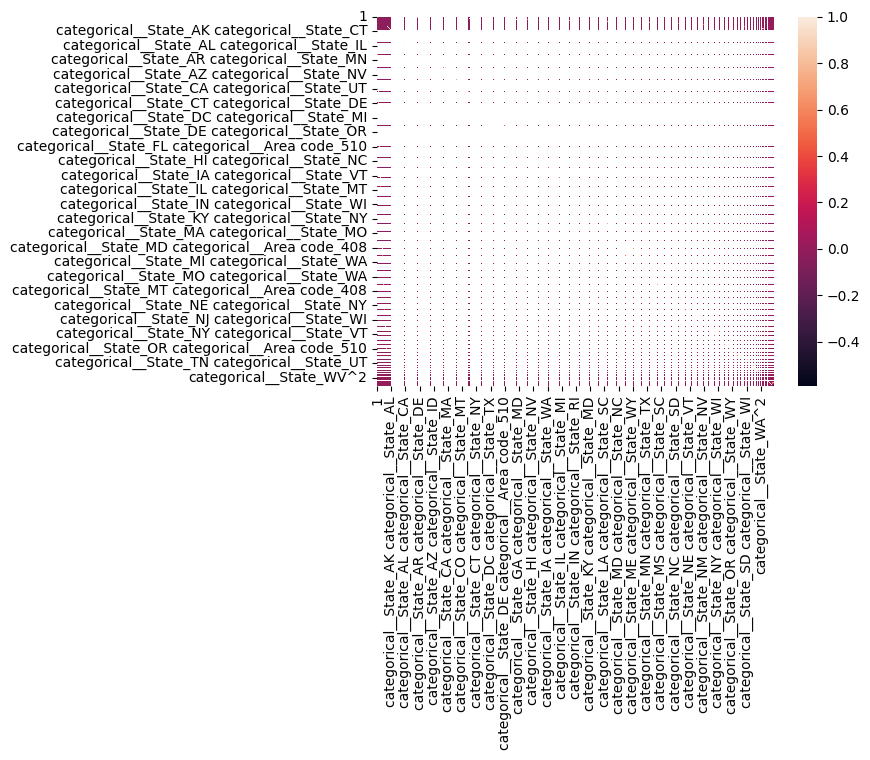

In [26]:
# Матрица корреляций признаков и целевой переменной
corr_matrix = DF_poly.corr()
sns.heatmap(corr_matrix)


Конечно же из-за добавления полиномов heatmap будет нечитаем, но при удалении коррелирующих признаков выведу списки удалённых переменных, может они будут не слишком большие

In [27]:
# Создаем списки для хранения удаленных признаков
removed_high_corr_features = []
removed_low_corr_features = []
# Выбираем признаки, которые сильно коррелируют друг с другом и создаём датафрейм с ними, в котором также есть столбец с абсолютным значением корреляции. Stack() преобразует датафрейм в серию, делая из столбцов строчки, reset_index() создаёт датафрейм из серии, rename() переименовывает потом столбец с корреляцией, который автоматически из-за reset_index был назван 0
highly_corr_features = corr_matrix[abs(corr_matrix) > 0.6].stack().reset_index().rename(columns={0:'corr'}) 
# Удаляем повторяющиеся пары признаков, то есть где признак коррелирует сам с собой
highly_corr_features = highly_corr_features[highly_corr_features['level_0']!=highly_corr_features['level_1']] 
# Удаляем признаки, которые сильно коррелируют друг с другом
for i in range(len(highly_corr_features)):
    feature1 = highly_corr_features.iloc[i]['level_0']
    feature2 = highly_corr_features.iloc[i]['level_1']
    if abs(corr_matrix.loc[feature1, 'churn']) > abs(corr_matrix.loc[feature2, 'churn']):
        if feature2 in DF_poly.columns:
            DF_poly = DF_poly.drop(columns=[feature2])
            removed_high_corr_features.append(feature2)
    else:
        if feature1 in DF_poly.columns:
            DF_poly = DF_poly.drop(columns=[feature1])
            removed_high_corr_features.append(feature1)
            
# Создаем список признаков, которые слабо коррелируют с целевой переменной 'churn'
low_corr_features = corr_matrix[abs(corr_matrix['churn']) < 0.1].index
# Удаляем признаки, которые слабо коррелируют с целевой переменной 'churn'
for feature in low_corr_features:
    if feature in DF_poly.columns:
        DF_poly = DF_poly.drop(columns=[feature])
        removed_low_corr_features.append(feature)

# Выводим удаленные признаки
print("Удален из-за высокой корреляции с другими признаками:", removed_high_corr_features)
print("Удален из-за низкой корреляции с целевой переменной:", removed_low_corr_features)

Удален из-за высокой корреляции с другими признаками: ['categorical__State_AK', 'categorical__State_AL', 'categorical__State_AL categorical__Area code_415', 'categorical__State_AR', 'categorical__State_AR categorical__Area code_415', 'categorical__State_AZ', 'categorical__State_AZ categorical__Area code_415', 'categorical__State_CA', 'categorical__State_CO', 'categorical__State_CT', 'categorical__State_CT categorical__Area code_415', 'categorical__State_DC', 'categorical__State_DE', 'categorical__State_DE categorical__Area code_415', 'categorical__State_FL', 'categorical__State_FL categorical__Area code_415', 'categorical__State_GA', 'categorical__State_HI', 'categorical__State_IA', 'categorical__State_IA categorical__Area code_415', 'categorical__State_IA categorical__Area code_510', 'categorical__State_ID', 'categorical__State_ID categorical__Area code_415', 'categorical__State_IL', 'categorical__State_IN', 'categorical__State_KS', 'categorical__State_KY', 'categorical__State_KY cate

In [28]:
print(DF_poly)

        1  categorical__State_AK categorical__State_AL  \
0     1.0                                          0.0   
1     1.0                                          0.0   
2     1.0                                          0.0   
3     1.0                                          0.0   
4     1.0                                          0.0   
...   ...                                          ...   
3328  1.0                                          0.0   
3329  1.0                                          0.0   
3330  1.0                                          0.0   
3331  1.0                                          0.0   
3332  1.0                                          0.0   

      categorical__State_AK categorical__State_AR  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                     

In [29]:
#A для новой модели
param_grid = {'logis__penalty':['l2'], 
              'logis__C': np.arange(5.6, 5.8, 0.01)} # поиск сначала был шире, но сужался, чтобы приблизиться ближе к оптимальному значению параметра регуляризации C. Наилучшие параметры: {'logis__C': 0.7666999999999993, 'logis__penalty': 'l2'}
              

# Конечная модель 
logmodel = Pipeline(steps=[
    ('scaler', MaxAbsScaler()),
    ('logis', LogisticRegression(max_iter=10000, class_weight={0:1, 1:5}))])

grid_search = GridSearchCV(logmodel, param_grid, cv=5, scoring='f1') # для валидации был выбран f1, так как он учитывает и полноту, и точность. А в данном случае нам важны оба этих параметра, поясню потом

grid_search.fit(DF_poly, y) # обучение модели с помощью GridSearchCV который подобрали выше

print("Наилучшие параметры:", grid_search.best_params_) # лучшие параметры


best_model = grid_search.best_estimator_ # лучшая модель

print('Cross Validation Precision:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='precision').mean())
print('Cross Validation Recall:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='recall').mean())
print('Cross Validation Accuracy:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='accuracy').mean())
print('Cross Validation F1:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='f1').mean())
print('Cross Validation ROC AUC:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='roc_auc').mean())

Наилучшие параметры: {'logis__C': 5.6, 'logis__penalty': 'l2'}
Cross Validation Precision: 0.17739203169711643
Cross Validation Recall: 0.07250859106529209
Cross Validation Accuracy: 0.8094740917829373
Cross Validation F1: 0.09998936465019435
Cross Validation ROC AUC: 0.507158900795804


In [31]:
#B для новой модели
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {'svc__C': np.arange(0.5, 0.7, 0.01), 'svc__kernel': ['linear']} # поиск сначала был шире, но сужался, чтобы приблизиться ближе к оптимальному значению параметра регуляризации C. Best Parameters: {'svc__C': 2.0345000000000093, 'svc__kernel': 'linear'}
# Конечная модель
svcmodel = Pipeline(steps=[
    ('scaler', MaxAbsScaler()),
    ('svc', SVC(class_weight={0:1, 1:5}))])
grid = GridSearchCV(svcmodel, param_grid, cv=5, scoring='f1') # для валидации был выбран f1, так как он учитывает и полноту, и точность. А в данном случае нам важны оба этих параметра, поясню потом
grid.fit(DF_poly, y)
best_model = grid.best_estimator_ # лучшая модель
print('Наилучшие параметры:', grid.best_params_) # лучшие параметры
print('Cross Validation Precision:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='precision').mean())
print('Cross Validation Recall:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='recall').mean())
print('Cross Validation Accuracy:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='accuracy').mean())
print('Cross Validation F1:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='f1').mean())
print('Cross Validation ROC AUC:', cross_val_score(best_model, DF_poly, y, cv = 5, scoring='roc_auc').mean())

Наилучшие параметры: {'svc__C': 0.51, 'svc__kernel': 'linear'}


/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross Validation Precision: 0.052951009386652946
Cross Validation Recall: 0.04765893470790378
Cross Validation Accuracy: 0.8154701928315122
Cross Validation F1: 0.04992123227726238
Cross Validation ROC AUC: 0.5028708853318864


Ваш отчет здесь.

**E. (1 балл)** Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC?
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).
Делалась оценка параметров по кросс валидации на 5 фолдах.
Для пунктов A и B
Для логистической регрессии: 
Cross Validation Precision: 0.1909224838401487
Cross Validation Recall: 0.42646048109965634
Cross Validation Accuracy: 0.652559756157957 
Cross Validation F1: 0.2632197187568601
Cross Validation ROC AUC: 0.5662194414300356
Для метода опорных векторов:
Cross Validation Precision: 0.18846897550002692
Cross Validation Recall: 0.42643900343642616
Cross Validation Accuracy: 0.6483605044324684
Cross Validation F1: 0.2607048353909317
Cross Validation ROC AUC: 0.5591323966057756
(Сразу говорю, что accuracy по факту почти ни о чем не говорит нам, потому что присутствует сильный дисбаланс классов) 
Как видно, метод опорных векторов даёт чуть более низкие показатели, поэтому в пунктах A и B следует предпочесть классификатор пункта A - логистическую регрессию. Но, в целом, оба метода очень близки в данном случае. Вообще из-за несбалансированности классов конечно я не очень доволен качеством модели. Однако если мы отталкиваемся от того, что имеем, то Recall в 0.42 достаточно неплох. Мы можем угадать 42% клиентов, которые могут уйти к другому сотовому оператору. Как раз основная цель - угадать их. Цель - найти тех, кто уйдёт, и попытаться их оставить, организовав им какие-то скидки или что-то по типу того. Всё конечно зависит от маржи сотового оператора и от его гибкости. Если ему сильного убытка не принесет precision в 0.19, то норм (он будет выдавать скидки людям, которые не уйдут, и таких будет по 4 человека на каждого одного потенциально уходящего), если не норм, то было бы неплохо использовать иные методы или преобразовать выборку, чтобы не было такого дисбаланса, потому что даже балансирование классов не позволило достичь очень высоких показателей. Поскольку была применена регуляризация и если оглянемся на текст выше, то подозреваем, что оба алгоритма в целом нормально обучены. 
Для пунктов C и D
Для логистической регрессии: 
Cross Validation Precision: 0.17739203169711643
Cross Validation Recall: 0.07250859106529209
Cross Validation Accuracy: 0.8094740917829373
Cross Validation F1: 0.09998936465019435
Cross Validation ROC AUC: 0.507158900795804
Для метода опорных векторов:
Cross Validation Precision: 0.052951009386652946
Cross Validation Recall: 0.04765893470790378
Cross Validation Accuracy: 0.8154701928315122
Cross Validation F1: 0.04992123227726238
Cross Validation ROC AUC: 0.5028708853318864

Видно, что в целом после некоторых преобразований данных модель стала очень плохо обучаться и выдавать очень плохие метрики. Поэтому среди этих 4 вариантов выбираем логистическую регрессию, обучаемую в пункте A (можно взять и B, потому что разница невелика и на других данных СВМ может показать себя лучше). А так вообще recall в 0.42 достаточно неплох. Мы можем угадать 42% клиентов, которые могут уйти к другому сотовому оператору. Как раз основная цель - угадать их. А из-за несбалансированности классов в выборке (класса 0 значительно больше) получается очень маленький Precision. Наверно такие простые классификаторы просто плохо справляются с несбалансированными выборками, потому что ROC AUC в 56% - это всего на 6% выше, чем рандомное угадывание.
b) какие новые признаки вы добавили и какие признаки удалили?
Если мы говорим про пункты C и D, то 
Какие признаки добавили: 
полиномы
общее время звонков 
общее количество звонков 
среднее время звонков 
общая сумма оплаты 
средняя сумма оплаты за звонок 
Какие удалили:
Удалено множество полиномов, которые сложно перечислить из-за большого количества (около 300). Из  более оригинальных признаков удалены:
Из-за высокой корреляции друг с другом (corr>0.6, удалялся из пары тот, который слабее коррелировал с целевой переменной):
'Number vmail messages', 'Total day charge', 'Total minutes of calls', 'Total day minutes', 'Mean charge per call', 'Total eve charge', 'Total night minutes', 'Total intl minutes', 'Mean call minutes'
Из-за низкой корреляции с целевой переменной (corr<0.1):
'Account length', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night calls', 'Total night charge', 'Total intl calls', 'Total intl charge', 'Total calls'

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?
Необходимо учитывать то, что пункты C и D мы объединили по предложению авторов ДЗ. Из начальных + добавленных некатегориальных признаков, которых всего оказалось 22, было удалено 18. Ну конечно есть стойое подозрение на то, что модель просто напросто недообучилась, потому что по всей видимости были удалены факторы, которые по корреляции явно не подозреваются на оказывания влияния на целевую переменную, но в реальности присутствует зависимость целевой переменной от регрессора.

## Часть 2. Оценка качества моделей классификации (5 баллов).

**Задание 0. (0.25 балла)** Закончите определения, начинающиеся так:

    * accuracy - это доля правильных ответов относительно всех объектов в выборке 
    
    * точность (precision) - это доля правильных ответов, отнесённых к положительному классу, относительно всех объектов, отнесенных к положительному классу
    
    * полнота (recall) - это доля правильных положительных ответов относительно всех положительных объектов в выборке
    
    * TPR - это доля правильных положительных ответов относительно всех положительных объектов в выборке (то же самое, что и полнота)
    
    
Продолжите определения прямо в этой ячейке.

_______________________________________________________________________________________________

В этой части вы будете работать с данными в задаче скоринга. За работу с этими данными можно получить **5 баллов.**

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные).
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [4]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [5]:
df.shape

(689, 21)

**Задание 1. (0.25 балла)** Проверьте target на сбалансированность по классам, сделайте вывод.

In [6]:
print(df['target'].value_counts())

target
0    382
1    307
Name: count, dtype: int64


In [7]:
print('Class 0:', 382/(382+307)*100,'%') 
print('Class 1:', 307/(382+307)*100,'%') 

Class 0: 55.442670537010166 %
Class 1: 44.55732946298984 %


**Задание 2. (0.25 балла)** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [10]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [11]:
print('Accuracy for 1:', accuracy_score(df['target'], df['pred1_classes']))

print('Accuracy for 2:', accuracy_score(df['target'], df['pred2_classes']))

print('Accuracy for 3:', accuracy_score(df['target'], df['pred3_classes']))

Accuracy for 1: 0.6618287373004355
Accuracy for 2: 0.6719883889695211
Accuracy for 3: 0.6400580551523948


Наибольшая accuracy у 2 алгоритма

**Задание 3. (0.25 балла)** Теперь вычислите точность и полноту каждого из алгоритмов.

In [12]:
print('Precision for 1:', precision_score(df['target'], df['pred1_classes']))
print('Recall for 1:', recall_score(df['target'], df['pred1_classes']))

print('Precision for 2:', precision_score(df['target'], df['pred2_classes']))
print('Recall for 2:', recall_score(df['target'], df['pred2_classes']))

print('Precision for 3:', precision_score(df['target'], df['pred3_classes']))
print('Recall for 3:', recall_score(df['target'], df['pred3_classes']))

Precision for 1: 0.6907216494845361
Recall for 1: 0.4364820846905538
Precision for 2: 0.6103542234332425
Recall for 2: 0.7296416938110749
Precision for 3: 0.6903225806451613
Recall for 3: 0.3485342019543974


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4. (0.5 балла)** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [13]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

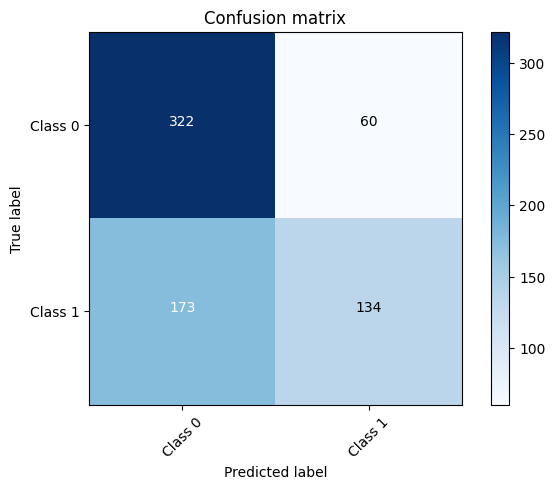

In [14]:
# Для 1 алгоритма
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['target'], df['pred1_classes'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

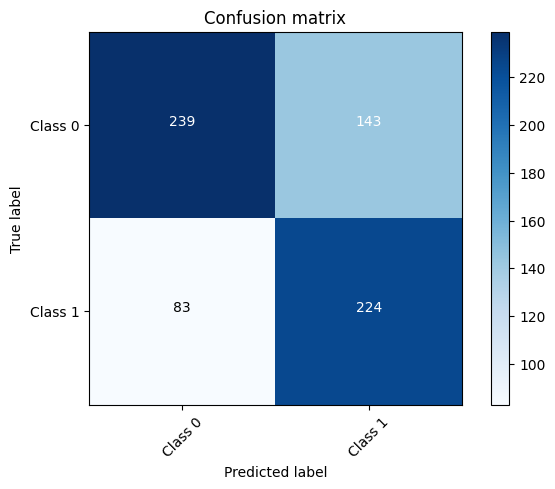

In [15]:
# Для 2 алгоритма

cm = confusion_matrix(df['target'], df['pred2_classes'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

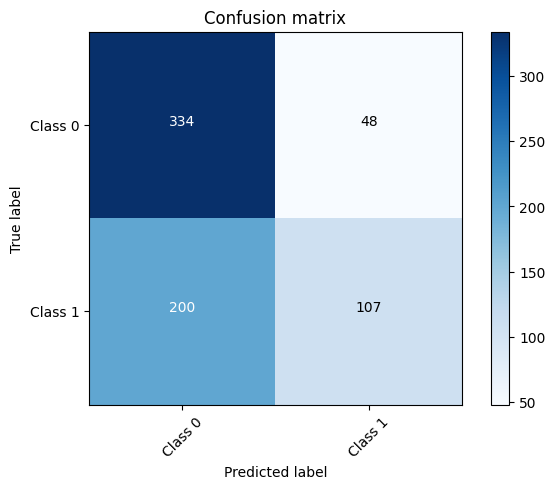

In [16]:
# Для 3 алгоритма

cm = confusion_matrix(df['target'], df['pred3_classes'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5. (0.5 балла)** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [17]:
# 1 алгоритм
best_threshold = 0
best_accuracy = 0
best_recall = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001): # перебираем пороги от 0 до 1 с шагом 0.001
    y_alg1 = (df['pred1_probs'] > threshold).astype(int) # преобразуем вероятности в классы
    accuracy = accuracy_score(df['target'], y_alg1) # считаем accuracy
    recall = recall_score(df['target'], y_alg1) #  считаем recall
    accuracy_thresholds.append(accuracy) # добавляем accuracy в список, это для себя проверить, норм ли работает

    
    if accuracy >= 0.65 and recall >= best_recall: # если accuracy больше или равно 0.65 и recall больше или равно лучшему recall, то обновляем порог, accuracy и recall
        best_recall = recall 
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg1 = pd.DataFrame({'Predict': y_alg1})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds}) # создаем датафрейм с порогами и accuracy, это для себя проверить, норм ли работает
print(accuracy_df['Accuracy'].value_counts())
print("Лучший порог для максимального recall:", best_threshold, ' при этом accuracy =', best_accuracy, ',а recall =', best_recall)

Accuracy
0.445573    261
0.663280     47
0.629898     31
0.664731     30
0.661829     25
           ... 
0.489115      1
0.486212      1
0.476052      1
0.632801      1
0.554427      1
Name: count, Length: 108, dtype: int64
Лучший порог для максимального recall: 0.359  при этом accuracy = 0.6502177068214804 ,а recall = 0.745928338762215


In [18]:
# 2 алгоритм
best_threshold = 0
best_accuracy = 0
best_recall = 0
for threshold in np.arange(0, 1.001, 0.001):
    y_alg2 = (df['pred2_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg2)
    recall = recall_score(df['target'], y_alg2)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and recall >= best_recall:
        best_recall = recall
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg2 = pd.DataFrame({'Predict': y_alg2})
print("Лучший порог для максимального recall:", best_threshold, ' при этом accuracy =', best_accuracy, ',а recall =', best_recall)

Лучший порог для максимального recall: 0.268  при этом accuracy = 0.6748911465892597 ,а recall = 0.8469055374592834


In [19]:
# 3 алгоритм
best_threshold = 0
best_accuracy = 0
best_recall = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001):
    y_alg3 = (df['pred3_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg3)
    recall = recall_score(df['target'], y_alg3)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and recall >= best_recall:
        best_recall = recall
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg3 = pd.DataFrame({'Predict': y_alg3})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds})
if accuracy_df['Accuracy'].ge(0.65).any() == False:
    print('Ни на одном пороге accuracy не достигает 0.65, поэтому в целом условие не выполняется для данного алгоритма')
print("Лучший порог для максимального recall:", best_threshold, ' при этом accuracy =', best_accuracy, ',а recall =', best_recall)

Ни на одном пороге accuracy не достигает 0.65
Лучший порог для максимального recall: 0  при этом accuracy = 0 ,а recall = 0


Порог нерелевантен, поскольку условие на accuracy не выполняется

**Задание 6. (0.5 балла)** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.

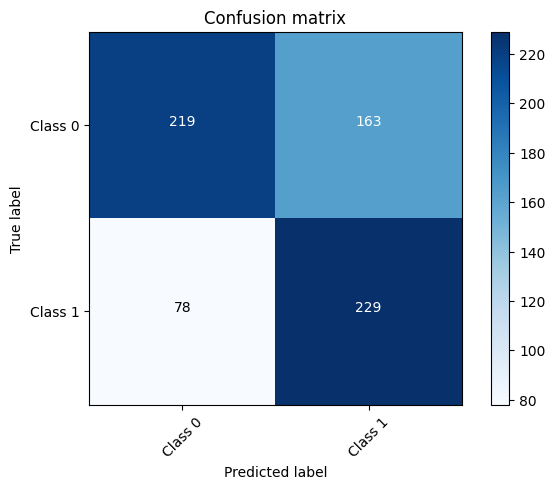

In [20]:
# Для 1 алгоритма
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['target'], df_alg1['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

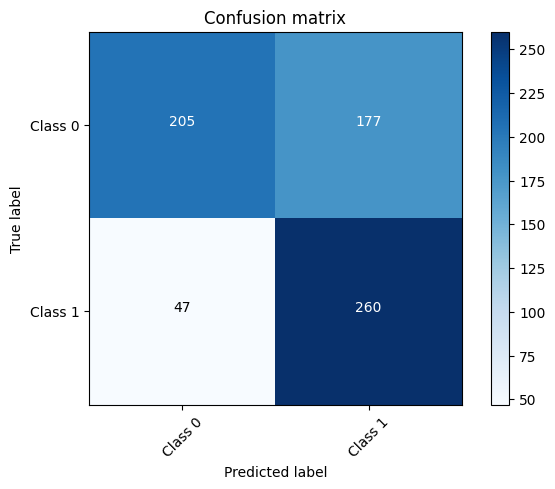

In [21]:
# Для 2 алгоритма

cm = confusion_matrix(df['target'], df_alg2['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [22]:
# Для 3 алгоритма

cm = confusion_matrix(df['target'], df_alg3['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

NameError: name 'df_alg3' is not defined

Для 3 алгоритма матрица нерелевантна, так как условие для accuracy не выполняется

**Выводы:** Лучше всего с задачей справляется второй алгоритм, у которого Recall = 0.84

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги).
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7. (0.5 балла)** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

In [ ]:
# 1 алгоритм
best_threshold = 0
best_accuracy = 0
best_precision = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001):
    y_alg1 = (df['pred1_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg1)
    precision = precision_score(df['target'], y_alg1, zero_division=1)
    accuracy_thresholds.append(accuracy)

    
    if accuracy >= 0.65 and precision >= best_precision:
        best_precision = precision
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg1_2 = pd.DataFrame({'Predict': y_alg1})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds})
print(accuracy_df['Accuracy'].value_counts())
print("Лучший порог для максимального precision:", best_threshold, ' при этом accuracy =', best_accuracy, ',а precision =', best_precision)

0.445573    261
0.663280     47
0.629898     31
0.664731     30
0.579100     25
           ... 
0.574746      1
0.476052      1
0.458636      1
0.492017      1
0.465893      1
Name: Accuracy, Length: 108, dtype: int64
Лучший порог для максимального precision: 0.54  при этом accuracy = 0.6618287373004355 ,а precision = 0.7371794871794872


In [ ]:
# 2 алгоритм
best_threshold = 0
best_accuracy = 0
best_precision = 0
for threshold in np.arange(0, 1.001, 0.001):
    y_alg2 = (df['pred2_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg2)
    precision = precision_score(df['target'], y_alg2, zero_division=1)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and precision >= best_precision:
        best_precision = precision
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg2_2 = pd.DataFrame({'Predict': y_alg2})
print("Лучший порог для максимального precision:", best_threshold, ' при этом accuracy =', best_accuracy, 'а precision =', best_precision)

Лучший порог для максимального precision: 0.756  при этом accuracy = 0.6502177068214804 а precision = 0.8367346938775511


In [ ]:
# 3 алгоритм
best_threshold = 0
best_accuracy = 0
best_precision = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001):
    y_alg3 = (df['pred3_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg3)
    precision = precision_score(df['target'], y_alg3, zero_division=1)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and precision >= best_precision:
        best_precision = precision
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg3_2 = pd.DataFrame({'Predict': y_alg3})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds})
if accuracy_df['Accuracy'].ge(0.65).any() == False:
    print('Ни на одном пороге accuracy не достигает 0.65, поэтому в целом условие не выполняется для данного алгоритма')
print("Лучший порог для максимального precision:", best_threshold, ' при этом accuracy =', best_accuracy, 'а precision =', best_precision)

Ни на одном пороге accuracy не достигает 0.65
Лучший порог для максимального precision: 0  при этом accuracy = 0 а precision = 0


Порог нерелевантен, поскольку условие на accuracy не выполняется

**Задание 8. (0.5 балла)** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?

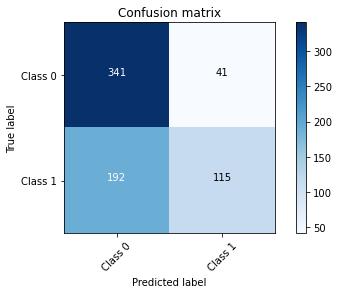

In [ ]:
# Для 1 алгоритма
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['target'], df_alg1_2['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

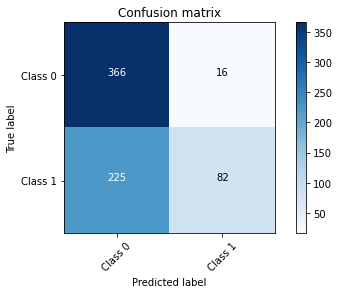

In [ ]:
# Для 2 алгоритма

cm = confusion_matrix(df['target'], df_alg2_2['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Для 3 алгоритма

cm = confusion_matrix(df['target'], df_alg3_2['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

NameError: name 'df_alg3_2' is not defined

Для 3 алгоритма матрица нерелевантна, так как условие для accuracy не выполняется

Лучше всего с задачей справляется второй алгоритм, у которого Precision = 0.837

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9. (0.5 балла)** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [ ]:
# 1 алгоритм
from sklearn.metrics import f1_score
best_threshold = 0
best_accuracy = 0
best_f1 = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001):
    y_alg1 = (df['pred1_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg1)
    f1 = f1_score(df['target'], y_alg1)
    accuracy_thresholds.append(accuracy)

    
    if accuracy >= 0.65 and f1 >= best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg1_3 = pd.DataFrame({'Predict': y_alg1})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds})
print(accuracy_df['Accuracy'].value_counts())
print("Лучший порог для максимального f1:", best_threshold, ' при этом accuracy =', best_accuracy, 'а f1 =', best_f1)

0.445573    261
0.663280     47
0.629898     31
0.664731     30
0.579100     25
           ... 
0.574746      1
0.476052      1
0.458636      1
0.492017      1
0.465893      1
Name: Accuracy, Length: 108, dtype: int64
Лучший порог для максимального f1: 0.359  при этом accuracy = 0.6502177068214804 а f1 = 0.6552217453505007


In [ ]:
# 2 алгоритм
best_threshold = 0
best_accuracy = 0
best_f1 = 0
for threshold in np.arange(0, 1.001, 0.001):
    y_alg2 = (df['pred2_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg2)
    f1 = f1_score(df['target'], y_alg2)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and f1 >= best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg2_3 = pd.DataFrame({'Predict': y_alg2})
print("Лучший порог для максимального f1:", best_threshold, ' при этом accuracy =', best_accuracy, 'а f1 =', best_f1)

Лучший порог для максимального f1: 0.327  при этом accuracy = 0.6850507982583455 а f1 = 0.6990291262135923


In [ ]:
# 3 алгоритм
best_threshold = 0
best_accuracy = 0
best_f1 = 0
accuracy_thresholds = []
for threshold in np.arange(0, 1.001, 0.001):
    y_alg3 = (df['pred3_probs'] > threshold).astype(int)
    accuracy = accuracy_score(df['target'], y_alg3)
    f1 = f1_score(df['target'], y_alg3)
    accuracy_thresholds.append(accuracy)
    
    if accuracy >= 0.65 and f1 >= best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_accuracy = accuracy
        df_alg3_3 = pd.DataFrame({'Predict': y_alg3})
accuracy_df = pd.DataFrame({'Threshold': np.arange(0, 1.001, 0.001), 'Accuracy': accuracy_thresholds})
if accuracy_df['Accuracy'].ge(0.65).any() == False:
    print('Ни на одном пороге accuracy не достигает 0.65, поэтому в целом условие не выполняется для данного алгоритма')
print("Лучший порог для максимального f1:", best_threshold, ' при этом accuracy =', best_accuracy, 'а f1 =', best_f1)

Ни на одном пороге accuracy не достигает 0.65
Лучший порог для максимального f1: 0  при этом accuracy = 0 а f1 = 0


Порог нерелевантен, поскольку условие на accuracy не выполняется

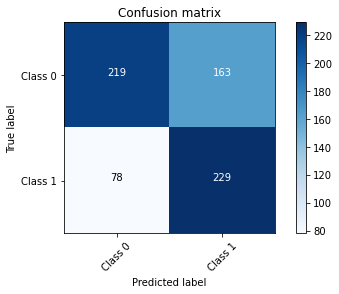

In [ ]:
# Для 1 алгоритма
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['target'], df_alg1_3['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

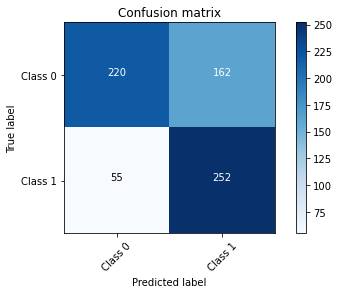

In [ ]:
# Для 2 алгоритма

cm = confusion_matrix(df['target'], df_alg2_3['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Для 3 алгоритма

cm = confusion_matrix(df['target'], df_alg3_3['Predict'])
plot_confusion_matrix(cm, ['Class 0', 'Class 1'],
                          normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

NameError: name 'df_alg3_3' is not defined

Для 3 алгоритма матрица нерелевантна, так как условие для accuracy не выполняется

Лучше всего с задачей справляется второй алгоритм, у которого F1 = 0.699

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df['target'], df['pred1_classes']))

### Обучим свою модель для предсказания target.

**Задание 10. (0.5 балла)** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

my_model = Pipeline([('scaler', StandardScaler()),
                       ('logistic', LogisticRegression())]) # создаем модель с помощью Pipeline из двух шагов: нормализация и логистическая регрессия
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, random_state=1) # разбиваем на train и test
my_model.fit(X_train, y_train) # обучаем модель
y_pred_proba = my_model.predict_proba(X_test) # делаем предсказание вероятностей



**Задание 11. (0.5 балла)** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность
    б) полноту
    в) f1-score.
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [26]:
# Максимизируем Точность
best_accuracy = 0 # инициализируем лучшую accuracy нулем чтоб всё работало
best_threshold = 0 # инициализируем лучшbq порог нулем чтоб всё работало
for threshold in np.arange(0.1, 0.9, 0.1): # проходим по порогам от 0.1 до 0.8 с шагом 0.1
    y_pred = (y_pred_proba[:,1] > threshold).astype(int) # предсказываем метки с помощью текущего порога
    accuracy = accuracy_score(y_test, y_pred) # вычисляем accuracy для предсказанных меток
    if accuracy > best_accuracy: # если текущая accuracy лучше лучшей accuracy до сих пор
        best_accuracy = accuracy # обновляем лучшую accuracy
        best_threshold = threshold  # обновляем порог, который дает лучшую accuracy
print('лучший порог для максимальной точности=', best_threshold, 'лучшая точность =', best_accuracy)
# Максимизируем Полноту
best_recall = 0 # инициализируем лучшую полноту нулем чтоб всё работало
best_recall_threshold = 0 # инициализируем порог, который дает лучшую полноту, нулем
for threshold in np.arange(0.1, 0.9, 0.1): # проходим по порогам от 0.1 до 0.8 с шагом 0.1
    y_pred = (y_pred_proba[:,1] > threshold).astype(int) # предсказываем метки с помощью текущего порога
    recall = recall_score(y_test, y_pred) # вычисляем полноту для предсказанных меток
    if recall > best_recall: # если текущая полнота лучше лучшей полноты до сих пор
        best_recall = recall # обновляем лучшую полноту
        best_recall_threshold = threshold # обновляем порог, который дает лучшую полноту
print('лучший порог для максимальной полноты =', best_recall_threshold, 'лучшая полнота =', best_recall)
# Максимизируем F1-меру
best_f1 = 0 # инициализируем лучшую F1-меру нулем
best_f1_threshold = 0 # инициализируем порог, который дает лучшую F1-меру, нулем
for threshold in np.arange(0.1, 0.9, 0.1): # проходим по порогам от 0.1 до 0.8 с шагом 0.1
    y_pred = (y_pred_proba[:,1] > threshold).astype(int) # предсказываем метки с помощью текущего порога
    f1 = f1_score(y_test, y_pred) # вычисляем F1-меру для предсказанных меток
    if f1 > best_f1: # если текущая F1-мера лучше лучшей F1-меры до сих пор
        best_f1 = f1 # обновляем лучшую F1-меру
        best_f1_threshold = threshold # обновляем порог, который дает лучшую F1-меру
print('лучший порог для максимальной F1-меры =', best_f1_threshold, 'лучшая F1-мера =', best_f1) # выводим порог, который дает лучшую F1-меру, и лучшую F1-меру


лучший порог для максимальной точности= 0.5 лучшая точность = 0.9082125603864735
лучший порог для максимальной полноты = 0.1 лучшая полнота = 0.9647058823529412
лучший порог для максимальной F1-меры = 0.5 лучшая F1-мера = 0.8914285714285715


Вывод: да, как видно, логистическая регрессия значительно лучше предсказывает, чем даже второй алгоритм.